# Step1 : **Importing Libraries**

In [1]:
#Basic
import numpy as np
import pandas as pd
import os
import shutil
import random
import PIL
#visuals
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
from PIL import Image

#Tensorflow
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout ,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator


#Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

import warnings
warnings.filterwarnings('ignore')


# **Step2 : Data Preprocessing**

## Read Data and store it in dataframe

In [2]:
data='/kaggle/input/microsoft-catsvsdogs-dataset/PetImages'
file_path=[]
label_path=[]

folder=os.listdir(data) 
for fold in folder:
    folder_path=os.path.join(data,fold)
    file_list=os.listdir(folder_path)
    for file in file_list:
        filepath=os.path.join(folder_path,file)
        file_path.append(filepath)
        label_path.append(fold)

In [3]:
# Concatenate data paths with labels into one dataframe
file_series=pd.Series(file_path,name='file_path')
label_series=pd.Series(label_path,name='label_path')
df=pd.concat([file_series,label_series],axis=1)

In [4]:
df

,file_path,label_path
0,/kaggle/input/microsoft-catsvsdogs-dataset/Pet...,Dog
1,/kaggle/input/microsoft-catsvsdogs-dataset/Pet...,Dog
2,/kaggle/input/microsoft-catsvsdogs-dataset/Pet...,Dog
3,/kaggle/input/microsoft-catsvsdogs-dataset/Pet...,Dog
4,/kaggle/input/microsoft-catsvsdogs-dataset/Pet...,Dog
...,...,...
24997,/kaggle/input/microsoft-catsvsdogs-dataset/Pet...,Cat
24998,/kaggle/input/microsoft-catsvsdogs-dataset/Pet...,Cat
24999,/kaggle/input/microsoft-catsvsdogs-dataset/Pet...,Cat
25000,/kaggle/input/microsoft-catsvsdogs-dataset/Pet...,Cat


In [5]:
# Counting the occurrences of each unique value in the 'Label_path' column
df['label_path'].value_counts()

label_path
Dog    12501
Cat    12501
Name: count, dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25002 entries, 0 to 25001
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   file_path   25002 non-null  object
 1   label_path  25002 non-null  object
dtypes: object(2)
memory usage: 390.8+ KB


Check Image if Valid or not



In [7]:
df.isnull().any().describe()

count         2
unique        1
top       False
freq          2
dtype: object

In [10]:
# Function to handle potentially corrupted images
def is_valid_image(file_path):
    try:
        img = Image.open(file_path)
        img.verify()  # Verify that it is a readable image
        return True
    except (IOError, SyntaxError, PIL.UnidentifiedImageError):
        return False

# Filter the dataframe to remove invalid images
df['is_valid'] = df['file_path'].apply(is_valid_image)

In [11]:
df['is_valid'].value_counts()

is_valid
True     24998
False        4
Name: count, dtype: int64

In [12]:
df[df['is_valid']== False]

,file_path,label_path,is_valid
3389,/kaggle/input/microsoft-catsvsdogs-dataset/Pet...,Dog,False
8246,/kaggle/input/microsoft-catsvsdogs-dataset/Pet...,Dog,False
20747,/kaggle/input/microsoft-catsvsdogs-dataset/Pet...,Cat,False
22300,/kaggle/input/microsoft-catsvsdogs-dataset/Pet...,Cat,False


In [13]:
df = df[df['is_valid']].drop(columns='is_valid')

In [14]:
df['label'] = df['label_path'].map({'Cat': 0, 'Dog': 1})
print(df.head())
print(df.tail())

                                           file_path label_path  label
0  /kaggle/input/microsoft-catsvsdogs-dataset/Pet...        Dog      1
1  /kaggle/input/microsoft-catsvsdogs-dataset/Pet...        Dog      1
2  /kaggle/input/microsoft-catsvsdogs-dataset/Pet...        Dog      1
3  /kaggle/input/microsoft-catsvsdogs-dataset/Pet...        Dog      1
4  /kaggle/input/microsoft-catsvsdogs-dataset/Pet...        Dog      1
                                               file_path label_path  label
24997  /kaggle/input/microsoft-catsvsdogs-dataset/Pet...        Cat      0
24998  /kaggle/input/microsoft-catsvsdogs-dataset/Pet...        Cat      0
24999  /kaggle/input/microsoft-catsvsdogs-dataset/Pet...        Cat      0
25000  /kaggle/input/microsoft-catsvsdogs-dataset/Pet...        Cat      0
25001  /kaggle/input/microsoft-catsvsdogs-dataset/Pet...        Cat      0


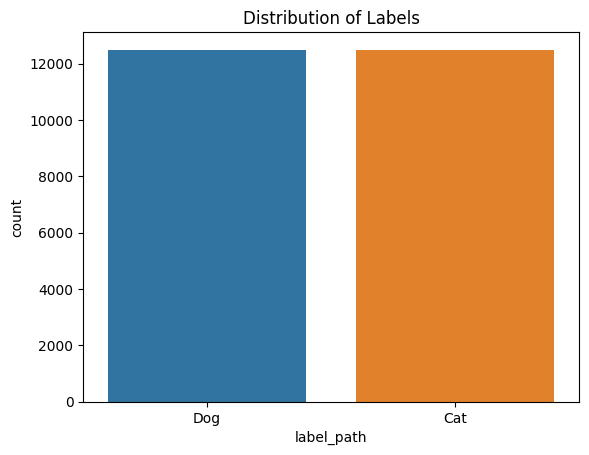

In [15]:
sns.countplot(x='label_path', data=df)
plt.title('Distribution of Labels')
plt.show()


In [16]:
df.shape

(24998, 3)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24998 entries, 0 to 25001
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   file_path   24998 non-null  object
 1   label_path  24998 non-null  object
 2   label       24998 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 781.2+ KB


# **Step3 : Visualization of image**a

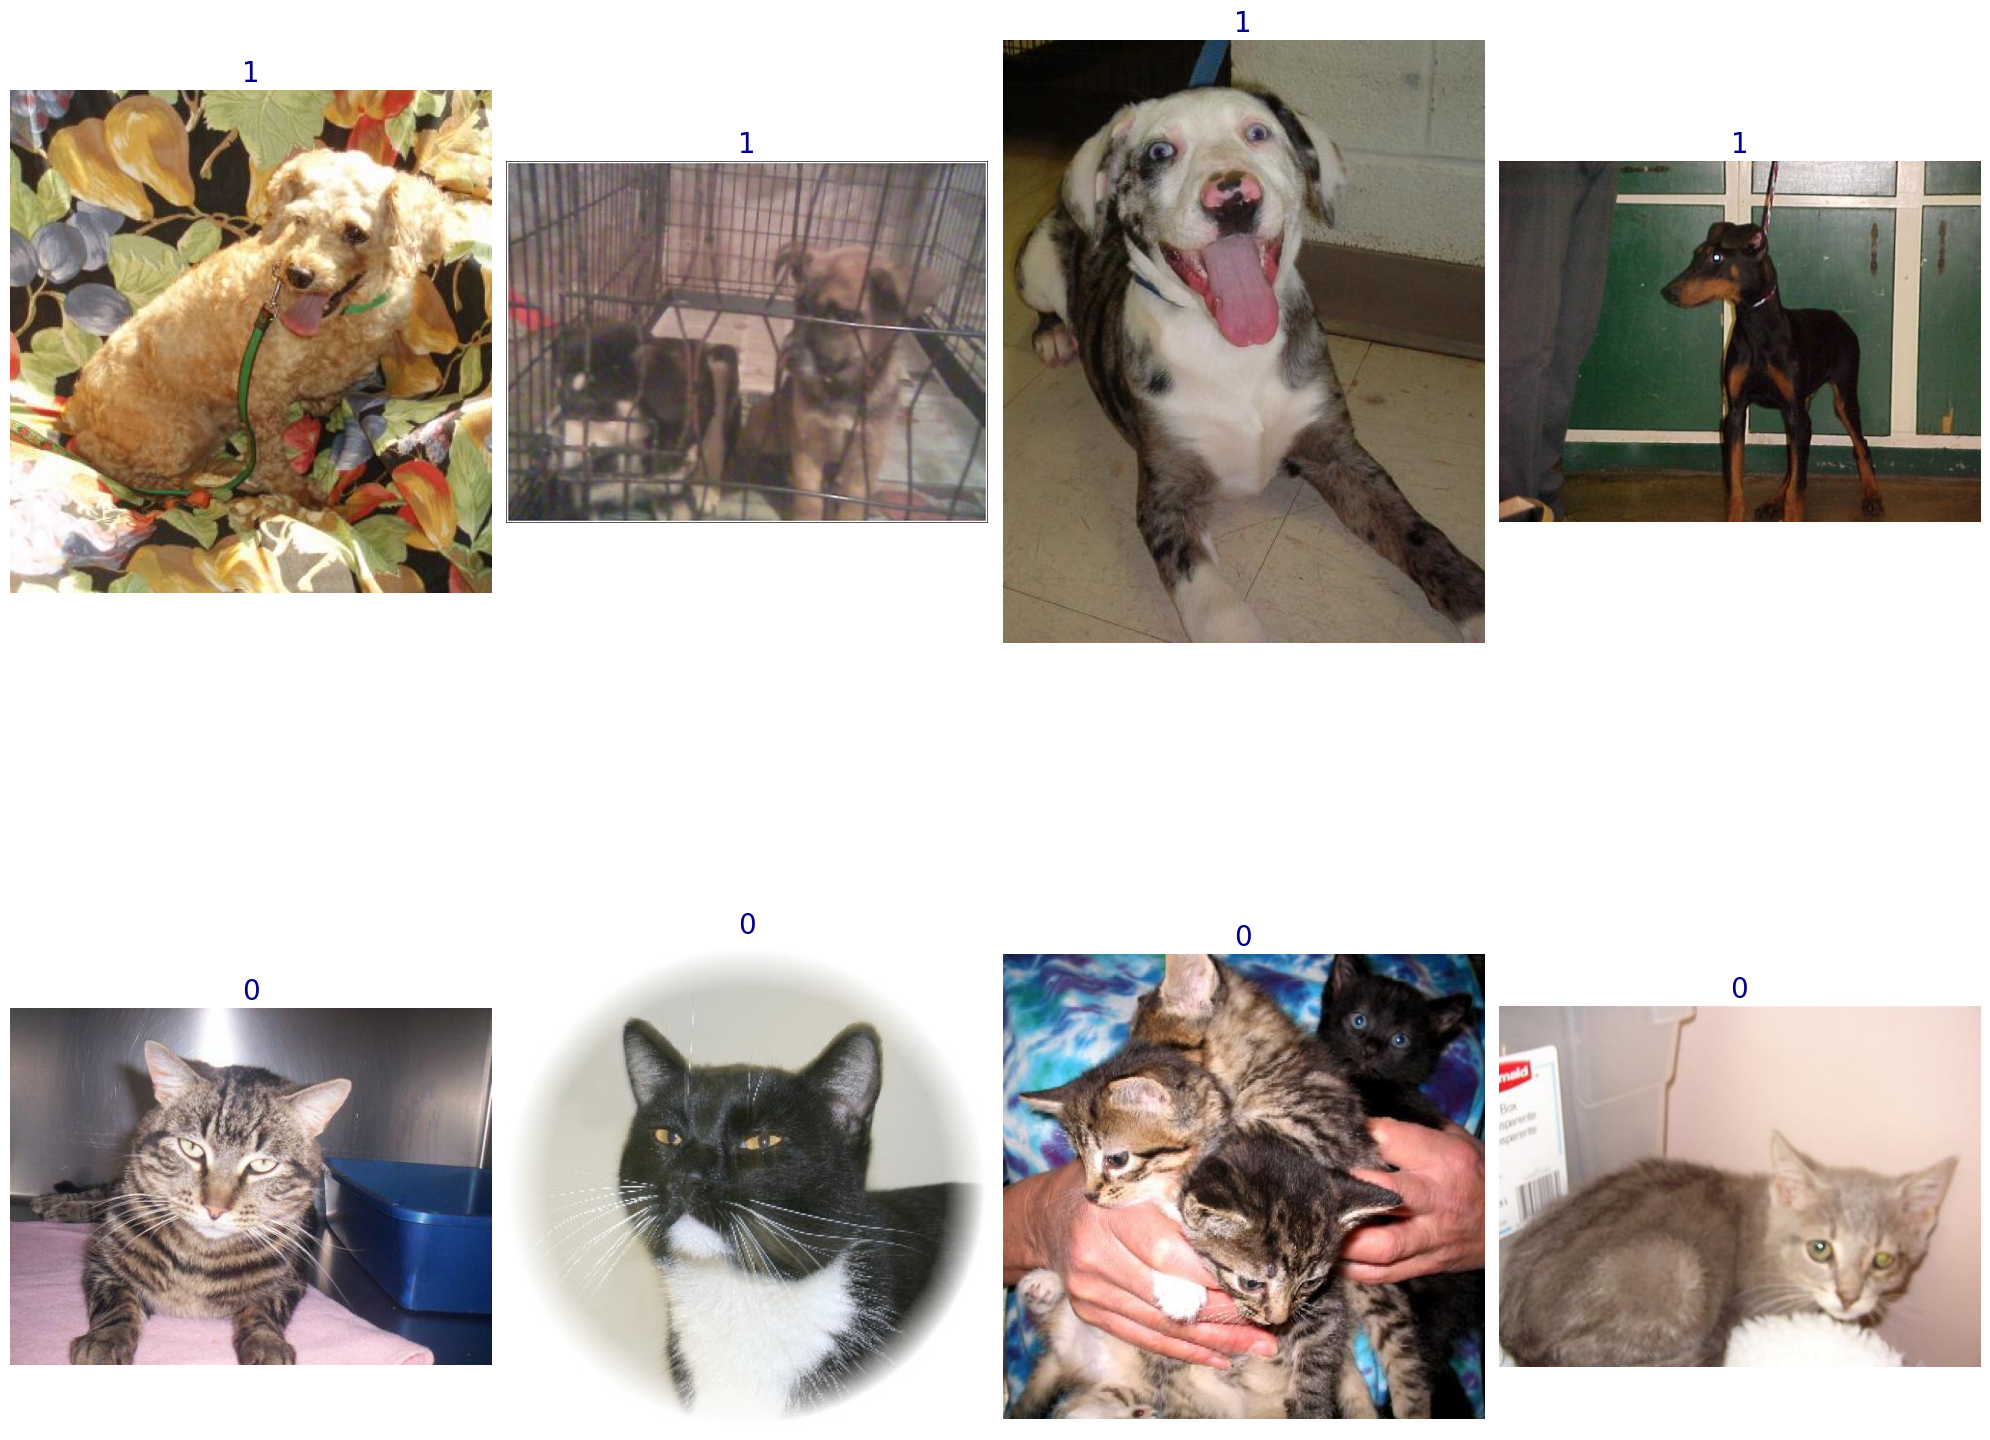

In [18]:
# Set the number of images to display per species
num_images = 4

# Get unique animal species labels
species = df['label'].unique()

# Set up the plot
plt.figure(figsize=(20, 20))

# Loop through each animal species
for idx, anmal in enumerate(species):
    # Filter the DataFrame to get file paths for this animal species
    animal_df = df[df['label'] == anmal].sample(num_images)  # Get a random sample of 16 images
    
    # Loop through the 16 images and plot them
    for i, file in enumerate(animal_df['file_path'].values):
        plt.subplot(len(species), num_images, idx * num_images + i + 1)
        img = Image.open(file)
        plt.imshow(img)
        plt.axis('off')
        plt.title(anmal, fontdict={'fontsize': 20, 'color': 'darkblue'})
        
# Show the plot
plt.tight_layout()
plt.show()

 # **Step4 : Spliting the data into Training and Testing**

In [19]:
# Splitting dataset
X = df['label']
train_df, dummy_df = train_test_split(df, test_size=.3, shuffle=True, random_state=123, stratify=X)

In [20]:
# valid and test dataframe
X = dummy_df['label']
valid_df, test_df = train_test_split(dummy_df, test_size=.3, shuffle=True, random_state=123, stratify=X)

In [21]:
print(f"Number of Training dataset: {len(train_df)}")
print(f"Number of Validation dataset: {len(valid_df)}")
print(f"Number of Testing dataset: {len(test_df)}")

Number of Training dataset: 17498
Number of Validation dataset: 5250
Number of Testing dataset: 2250


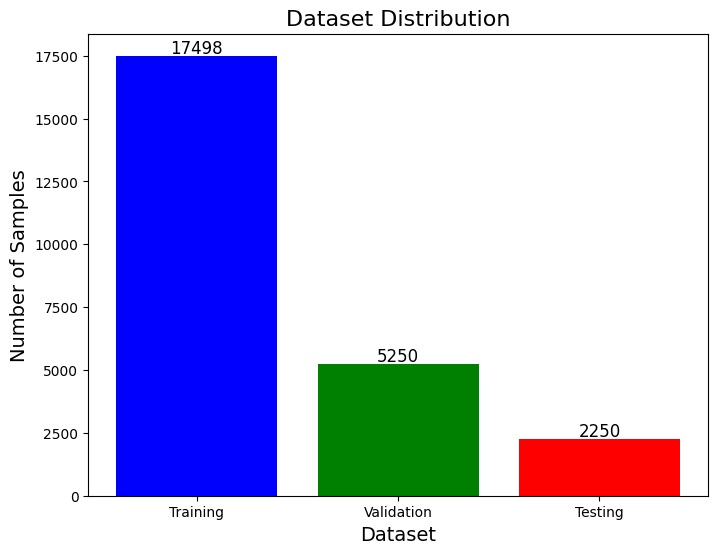

In [22]:
train_size = len(train_df)
valid_size = len(valid_df)
test_size = len(test_df)

categories = ['Training', 'Validation', 'Testing']
sizes = [train_size, valid_size, test_size]

plt.figure(figsize=(8, 6))
plt.bar(categories, sizes, color=['blue', 'green', 'red'])
plt.title('Dataset Distribution', fontsize=16)
plt.xlabel('Dataset', fontsize=14)
plt.ylabel('Number of Samples', fontsize=14)
for i, size in enumerate(sizes):
    plt.text(i, size + 100, str(size), ha='center', fontsize=12)

plt.show()


# **Step5 : Create image data generator**

In [23]:
def load_and_preprocess_image(file_path, target_size=(224, 224)):
    img = Image.open(file_path).resize(target_size)
    img_array = np.array(img) / 255.0  
    return img_array


image = load_and_preprocess_image(train_df['file_path'].iloc[0])



In [24]:
image

array([[[0.48235294, 0.42745098, 0.36470588],
        [0.48235294, 0.42745098, 0.36862745],
        [0.47843137, 0.42745098, 0.36470588],
        ...,
        [0.29803922, 0.29019608, 0.29411765],
        [0.31764706, 0.31764706, 0.31764706],
        [0.40392157, 0.40392157, 0.40392157]],

       [[0.49411765, 0.44705882, 0.38431373],
        [0.49411765, 0.44705882, 0.38431373],
        [0.49411765, 0.44313725, 0.38039216],
        ...,
        [0.24313725, 0.23921569, 0.24313725],
        [0.31372549, 0.31372549, 0.31372549],
        [0.38039216, 0.38039216, 0.38039216]],

       [[0.47843137, 0.44313725, 0.37647059],
        [0.4745098 , 0.43529412, 0.36862745],
        [0.50588235, 0.45882353, 0.39607843],
        ...,
        [0.19607843, 0.2       , 0.20392157],
        [0.27058824, 0.27058824, 0.2745098 ],
        [0.38039216, 0.38039216, 0.38431373]],

       ...,

       [[0.09019608, 0.09411765, 0.11372549],
        [0.08627451, 0.09019608, 0.10980392],
        [0.08627451, 0

In [25]:
# crobed image size
batch_size = 64
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator(rescale=1./255,
                                    rotation_range = 15,
                                    horizontal_flip = True,
                                    zoom_range = 0.2,
                                    shear_range = 0.1,
                                    fill_mode = 'reflect',
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1)

ts_gen = ImageDataGenerator(rescale=1./255)


train_gen = tr_gen.flow_from_dataframe(train_df, x_col='file_path', y_col='label_path', target_size=img_size, class_mode= 'categorical', 
                                       shuffle=True, batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='file_path', y_col='label_path', target_size=img_size, class_mode= 'categorical', 
                                       shuffle=True, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='file_path', y_col='label_path', target_size=img_size, class_mode= 'categorical', 
                                       shuffle=False, batch_size=batch_size)

Found 17498 validated image filenames belonging to 2 classes.
Found 5250 validated image filenames belonging to 2 classes.
Found 2250 validated image filenames belonging to 2 classes.


# **Step6 : Model Structure**

In [26]:
model = keras.models.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape= img_shape),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),


    Conv2D(256, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),


    Flatten(),
    Dense(512, activation = 'relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(2, activation='softmax')

])

In [27]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,268,290 (73.50 MB)

 Trainable params: 19,266,306 (73.50 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [28]:
early_stopping = EarlyStopping(patience=10)

plateau = ReduceLROnPlateau(
    patience=2,
    monitor='val_accuracy',
    verbose=1,
    factor=.5
)

In [29]:
fast_run = False
epochs=3 if fast_run else 50
history = model.fit(train_gen, epochs=epochs, validation_data=valid_gen, verbose=1, 
                    shuffle=False , callbacks=[early_stopping, plateau])

Epoch 1/50


I0000 00:00:1729953344.481939     121 service.cc:145] XLA service 0x79842c0020d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729953344.482003     121 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  2/274 ━━━━━━━━━━━━━━━━━━━━ 19s 72ms/step - accuracy: 0.5781 - loss: 1.4812   

I0000 00:00:1729953357.540020     121 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


274/274 ━━━━━━━━━━━━━━━━━━━━ 255s 873ms/step - accuracy: 0.5904 - loss: 1.0090 - val_accuracy: 0.6168 - val_loss: 0.6487 - learning_rate: 0.0010
Epoch 2/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 231s 845ms/step - accuracy: 0.7166 - loss: 0.5625 - val_accuracy: 0.6794 - val_loss: 0.6602 - learning_rate: 0.0010
Epoch 3/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 229s 836ms/step - accuracy: 0.7788 - loss: 0.4673 - val_accuracy: 0.7878 - val_loss: 0.4590 - learning_rate: 0.0010
Epoch 4/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 229s 836ms/step - accuracy: 0.8144 - loss: 0.4074 - val_accuracy: 0.7208 - val_loss: 0.5596 - learning_rate: 0.0010
Epoch 5/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 776ms/step - accuracy: 0.8484 - loss: 0.3454
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
274/274 ━━━━━━━━━━━━━━━━━━━━ 228s 832ms/step - accuracy: 0.8484 - loss: 0.3454 - val_accuracy: 0.6632 - val_loss: 0.9796 - learning_rate: 0.0010
Epoch 6/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 227s 828ms/step - accuracy: 0.8776 - l

# **Step7 : Display model performance**

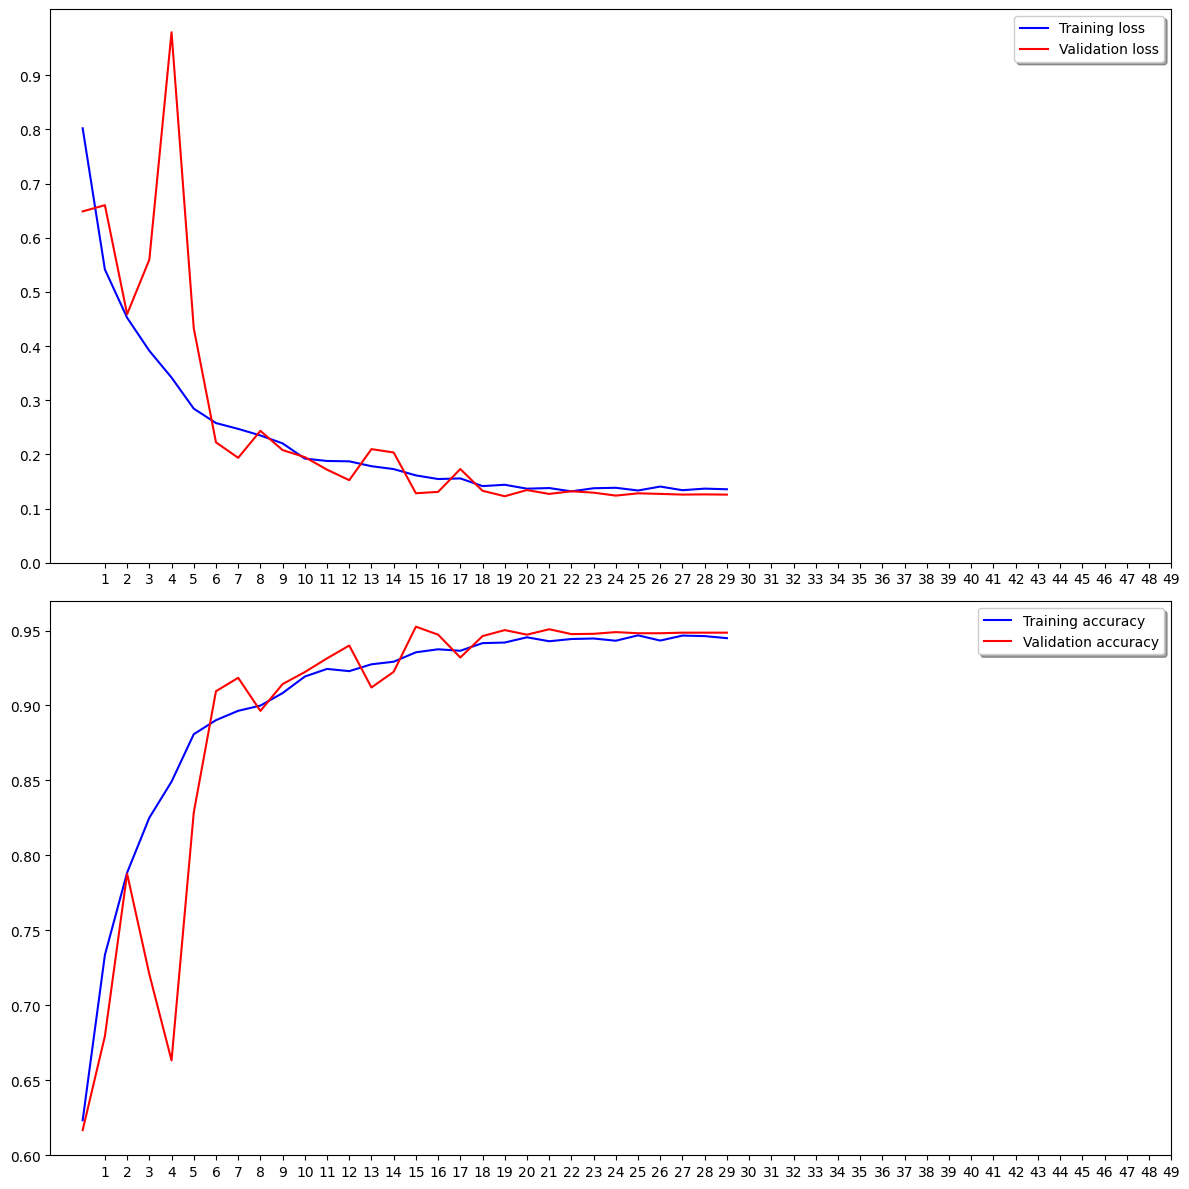

In [33]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="Validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))
ax1.legend(loc='best', shadow=True) 

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r', label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))
ax2.legend(loc='best', shadow=True)  

plt.tight_layout()
plt.show()

In [37]:
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

274/274 ━━━━━━━━━━━━━━━━━━━━ 231s 845ms/step - accuracy: 0.9571 - loss: 0.1057
83/83 ━━━━━━━━━━━━━━━━━━━━ 21s 259ms/step - accuracy: 0.9498 - loss: 0.1284
36/36 ━━━━━━━━━━━━━━━━━━━━ 33s 951ms/step - accuracy: 0.9465 - loss: 0.1194
Train Loss:  0.10386715829372406
Train Accuracy:  0.9581666588783264
--------------------
Valid Loss:  0.12584732472896576
Valid Accuracy:  0.9485714435577393
--------------------
Test Loss:  0.12863653898239136
Test Accuracy:  0.9426666498184204


In [39]:
preds  = model.predict(test_gen)

36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 193ms/step


In [49]:
preds

array([[3.6111850e-02, 9.6388817e-01],
       [9.8381746e-01, 1.6182538e-02],
       [9.9285215e-01, 7.1477811e-03],
       ...,
       [9.3120164e-01, 6.8798393e-02],
       [9.9999774e-01, 2.2411627e-06],
       [4.9040419e-01, 5.0959587e-01]], dtype=float32)

In [42]:
y_pred = np.argmax(preds, axis=1)
y_pred

array([1, 0, 0, ..., 0, 0, 1])

In [43]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

In [44]:
g_dict

{'Cat': 0, 'Dog': 1}

In [45]:
classes

['Cat', 'Dog']

In [ ]:
# Save the model 
model.save('model.h5')

In [ ]:
# Save the model 
model.save('model.h5')